In [28]:
%load_ext autoreload
%autoreload 2
import spacy
import scispacy
from scispacy.linking import EntityLinker
import en_core_sci_lg
from scify.nlp import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
text = "Spinal and bulbar muscular atrophy (SBMA) is an inherited motor neuron disease caused by the expansion of a polyglutamine tract within the androgen receptor (AR). SBMA can be caused by this easily."

In [3]:
from scispacy.abbreviation import AbbreviationDetector
from spacy.pipeline import merge_entities
from scispacy.linking import EntityLinker

nlp = load_sci_pipe()

In [5]:
#linker_umls = EntityLinker(resolve_abbreviations=True, name="umls")
#nlp.add_pipe(linker_umls)

In [15]:
from textacy.corpus import Corpus
from scify.consts import labels
from spacy.tokens import Doc, Token, Span
for label in labels:
    nlp.vocab.strings.add(label)

reannotate()
gnbr_500 = Corpus(nlp).load(nlp, "../data/experiments/GNBR_chem-gene_annotated_500")

#https://github.com/explosion/spaCy/issues/860
#doc = nlp(text)

In [7]:
from scify.utils.datasets import get_csv

dep_paths = get_csv("../data/experiments/GNBR_chem_gene_good_patterns_20k.csv")

## Get Most Potent Paths


In [8]:
dep_paths[:5]

[{'dependency_pattern': "['up-regulates|nsubj|start_entity up-regulates|dobj|end_entity', 1]",
  'occur_in_data': "['enhances|nsubj|start_entity enhances|nmod|up-regulation up-regulation|nmod|end_entity', 1]",
  None: ["['enhanced|nsubj|start_entity enhanced|dobj|end_entity', 1]",
   "['effects|nmod|start_entity diminished|dobj|effects diminished|nsubj|silencing silencing|nmod|end_entity', 1]",
   "['effect|nmod|start_entity abolished|dobj|effect abolished|nsubj|knock-down knock-down|nmod|end_entity', 1]",
   "['inhibited|nsubj|start_entity inhibited|dobj|end_entity', 37]",
   "['effects|nmod|start_entity reversed|dobj|effects reversed|nsubj|inhibition inhibition|nmod|end_entity', 1]",
   "['suppressed|nsubj|start_entity suppressed|dobj|activity activity|compound|end_entity', 2]",
   "['decreased|nsubj|start_entity decreased|dobj|amount amount|nmod|end_entity', 2]",
   "['inhibited|nsubj|start_entity inhibited|dobj|phosphorylation phosphorylation|nmod|end_entity', 21]",
   "['effects|n

## Apply to GNBR itself and check Syntactic Parsing accuracy of SciSpacy

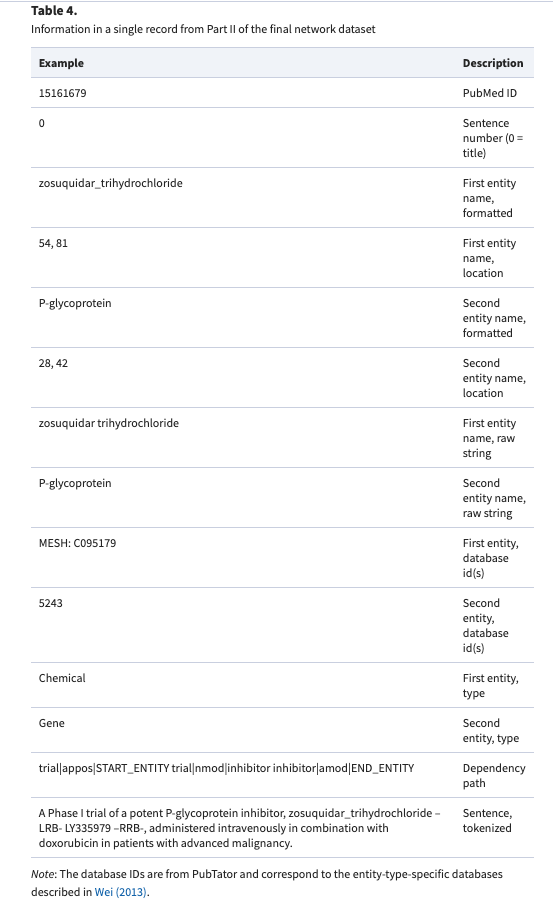

In [9]:
from IPython.display import Image
Image('../assets/GNBR_datafile_info.png')

## Precision on GNBR
Should be high since the clusters are annotated by humans ... the syntax parsing might make troubles

In [16]:
#get 10 strongest dep paths
wanted_abstr = [doc for doc in gnbr_500 if doc_has_entity_labels(doc,  [["CHEMICAL", "SIMPLE_CHEMICAL"], ["GENE", "GENE_OR_GENE_PRODUCT"]])]

target_sents =[sent for abstract in wanted_abstr for sent in abstract.sents if doc_has_entity_labels(sent,  [["CHEMICAL", "SIMPLE_CHEMICAL"], ["GENE", "GENE_OR_GENE_PRODUCT"]])]

len(wanted_abstr), len([sent for abstract in wanted_abstr for sent in abstract.sents ]), len(target_sents)


(207, 210, 206)

In [45]:
[ [k, v] for k,v in {"a": 5, "b": 4}.items()]

[['a', 5], ['b', 4]]

In [47]:
import csv
with open('numbers2.csv', 'w') as f:
    writer = csv.writer(f)
    
    for row in [ [k, v] for k,v in {"a": 5, "b": 4}.items()]:
        writer.writerow(row)

In [31]:
ents_w_candidates(target_sents[1])

[(c-Myc, ['GENE_OR_GENE_PRODUCT', 'PROTEIN']),
 (10058-F4, ['CHEMICAL', 'SIMPLE_CHEMICAL']),
 (induces, []),
 (cell-cycle arrest, ['DISEASE']),
 (apoptosis, []),
 (myeloid, ['CELL']),
 (human, ['TAXON', 'ORGANISM']),
 (acute_myeloid_leukemia, ['DISEASE'])]

In [ ]:
patterns = [
    "prevented|nsubj|START_ENTITY prevented|dobj|END_ENTITY",
    "causes|nsubj|START_ENTITY causes|dobj|END_ENTITY"
]

In [ ]:
#chem-gene or gene-chem
def match_wanted(subtree, start_entity=["CHEMICAL", "SIMPLE_CHEMICAL"], end_entity=["GENE", "GENE_OR_GENE_PRODUCT"]):
    """checks if match is a wanted pair. TODO: let construct_pattern handle this from the start
    subtree ~ [0, 5, 8]
    """
    

In [44]:
from typing import Tuple
def theme_support(dep_path, dist:Dict)->List[Tuple]:
    """get non-null GNBR supports for a given dependency path (needs distributions)"""
    supports = dist[dep_path].items()
    return [(a,b) for a,b in supports if b>0]

In [ ]:
matcher = add_matches(nlp.vocab, patterns)
matched_abstracts2 = match_texts(matcher, abstr[:200], nlp_NER)

## Precision on PubMed
Get pubmed sentences with Chem-Gene pairs (500 in the 750 abstracts) and see if there's some matches with the top dep patterns from GNBR

In [328]:
#invalid pattern
construct_pattern('causes|nsubj|END_ENTITY causes|dobj|START_ENTITY')

[{'SPEC': {'NODE_NAME': 'causes'}, 'PATTERN': {'LEMMA': 'cause'}},
 {'SPEC': {'NODE_NAME': 'END_ENTITY',
   'NBOR_RELOP': '>',
   'NBOR_NAME': 'causes'},
  'PATTERN': {'DEP': 'nsubj', 'POS': 'NOUN'}},
 {'SPEC': {'NODE_NAME': 'START_ENTITY',
   'NBOR_RELOP': '>',
   'NBOR_NAME': 'causes'},
  'PATTERN': {'DEP': 'dobj', 'POS': 'NOUN'}}]